[View in Colaboratory](https://colab.research.google.com/github/ozanpekmezci/capstone/blob/master/multi_digit_recognition_svhn.ipynb)

# Multi Digit Number Recognition with SVHN

This notebook implements multi digit number recognition using SVHN dataset that will be used to recognize house numbers at the streets. It can be considered as second version of the previous multi digit recognition which uses MNIST database. Keras and Tensorflow libraries are used to build the recognizer.
This recognizer extracts digit from the image using Convolutional Neural Network Classifier.

In [1]:
# Module Imports
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

from six.moves import cPickle as pickle
from six.moves import range


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Setting the random seed so that the results are reproducible. 
random.seed(42)


## Load Dataset

In [3]:
pickle_file = 'SVHN_multi_crop.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (27401, 64, 64) (27401, 5)
Validation set (6000, 64, 64) (6000, 5)
Test set (13068, 64, 64) (13068, 5)


Label for image: [ 7  5 10 10 10]


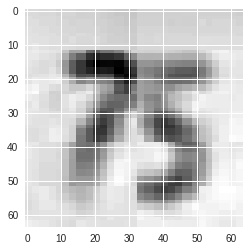

In [4]:
plt.figure()
plt.imshow(train_dataset[50], cmap='gray')

print("Label for image: {}".format(train_labels[50]))

## Convert Labels
This function converts each digit label to one-hot array.

In [0]:
# Converting labels to One-hot representations of shape (set_size, digits, classes)
possible_classes = 11

def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        # Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [0]:
train_labels = convert_labels(train_labels)
test_labels = convert_labels(test_labels)
valid_labels = convert_labels(valid_labels)

In [7]:
# Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(27401, 11)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [0]:
def prep_data_keras(img_data):
    
    # Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data), 64, 64, 1)
    
    # Converting everything to floats
    img_data = img_data.astype('float32')
    
    # Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data


In [0]:
train_images = prep_data_keras(train_dataset)
test_images = prep_data_keras(test_dataset)
valid_images = prep_data_keras(valid_dataset)

In [10]:
np.shape(train_images)

(27401, 64, 64, 1)

In [11]:
np.shape(test_images)

(13068, 64, 64, 1)

In [0]:
# Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adadelta, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


## Build Model
Build Deep Learning model to process data.

In [13]:
# Building the model

batch_size = 32
nb_classes = 11
nb_epoch = 24

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(1024, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
print (model.summary())


# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
# Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

11104/27401 [===========>..................] - ETA: 45s - loss: 7.2168 - dense_2_loss: 2.3865 - dense_3_loss: 2.8620 - dense_4_loss: 1.5939 - dense_5_loss: 0.3525 - dense_6_loss: 0.0219 - dense_2_acc: 0.3262 - dense_3_acc: 0.2064 - dense_4_acc: 0.6923 - dense_5_acc: 0.9539 - dense_6_acc: 0.9972

21888/27401 [======================>.......] - ETA: 14s - loss: 5.6632 - dense_2_loss: 1.8543 - dense_3_loss: 2.2609 - dense_4_loss: 1.2465 - dense_5_loss: 0.2881 - dense_6_loss: 0.0134 - dense_2_acc: 0.4424 - dense_3_acc: 0.3263 - dense_4_acc: 0.7093 - dense_5_acc: 0.9544 - dense_6_acc: 0.9985

27401/27401 [==============================] - 76s 3ms/step - loss: 5.1738 - dense_2_loss: 1.6803 - dense_3_loss: 2.0700 - dense_4_loss: 1.1479 - dense_5_loss: 0.2638 - dense_6_loss: 0.0117 - dense_2_acc: 0.4890 - dense_3_acc: 0.3729 - dense_4_acc: 0.7203 - dense_5_acc: 0.9559 - dense_6_acc: 0.9987 - val_loss: 2.7010 - val_dense_2_loss: 0.7928 - val_dense_3_loss: 1.0432 - val_dense_4_loss: 0.6517 - val_dense_5_loss: 0.2031 - val_dense_6_loss: 0.0102 - val_dense_2_acc: 0.7477 - val_dense_3_acc: 0.6665 - val_dense_4_acc: 0.8038 - val_dense_5_acc: 0.9578 - val_dense_6_acc: 0.9993
Epoch 2/24
 1728/27401 [>.............................] - ETA: 58s - loss: 2.9112 - dense_2_loss: 0.8934 - dense_3_loss: 1.1436 - dense_4_loss: 0.6972 - dense_5_loss: 0.1748 - dense_6_loss: 0.0022 - dense_2_acc: 0.6979 - dense_3_acc: 0.6244 - dense_4_acc: 0.7726 - dense_5_acc: 0.9543 - dense_6_acc: 1.0000

12512/27401 [============>.................] - ETA: 34s - loss: 2.7349 - dense_2_loss: 0.8228 - dense_3_loss: 1.0777 - dense_4_loss: 0.6653 - dense_5_loss: 0.1645 - dense_6_loss: 0.0047 - dense_2_acc: 0.7282 - dense_3_acc: 0.6479 - dense_4_acc: 0.7884 - dense_5_acc: 0.9576 - dense_6_acc: 0.9997

23328/27401 [========================>.....] - ETA: 9s - loss: 2.5666 - dense_2_loss: 0.7766 - dense_3_loss: 0.9997 - dense_4_loss: 0.6262 - dense_5_loss: 0.1607 - dense_6_loss: 0.0034 - dense_2_acc: 0.7455 - dense_3_acc: 0.6730 - dense_4_acc: 0.8006 - dense_5_acc: 0.9580 - dense_6_acc: 0.9998

27401/27401 [==============================] - 67s 2ms/step - loss: 2.5094 - dense_2_loss: 0.7617 - dense_3_loss: 0.9784 - dense_4_loss: 0.6114 - dense_5_loss: 0.1548 - dense_6_loss: 0.0030 - dense_2_acc: 0.7504 - dense_3_acc: 0.6795 - dense_4_acc: 0.8056 - dense_5_acc: 0.9593 - dense_6_acc: 0.9998 - val_loss: 1.7446 - val_dense_2_loss: 0.5086 - val_dense_3_loss: 0.6386 - val_dense_4_loss: 0.4495 - val_dense_5_loss: 0.1377 - val_dense_6_loss: 0.0102 - val_dense_2_acc: 0.8402 - val_dense_3_acc: 0.8065 - val_dense_4_acc: 0.8687 - val_dense_5_acc: 0.9618 - val_dense_6_acc: 0.9993
Epoch 3/24
 2208/27401 [=>............................] - ETA: 58s - loss: 2.0274 - dense_2_loss: 0.6179 - dense_3_loss: 0.7598 - dense_4_loss: 0.5142 - dense_5_loss: 0.1353 - dense_6_loss: 2.2145e-04 - dense_2_acc: 0.7994 - dense_3_acc: 0.7514 - dense_4_acc: 0.8356 - dense_5_acc: 0.9620 - dense_6_acc: 1.0000

12992/27401 [=============>................] - ETA: 33s - loss: 1.9553 - dense_2_loss: 0.5957 - dense_3_loss: 0.7439 - dense_4_loss: 0.4862 - dense_5_loss: 0.1272 - dense_6_loss: 0.0023 - dense_2_acc: 0.8071 - dense_3_acc: 0.7623 - dense_4_acc: 0.8464 - dense_5_acc: 0.9630 - dense_6_acc: 0.9998

23808/27401 [=========================>....] - ETA: 8s - loss: 1.9305 - dense_2_loss: 0.5871 - dense_3_loss: 0.7269 - dense_4_loss: 0.4832 - dense_5_loss: 0.1300 - dense_6_loss: 0.0033 - dense_2_acc: 0.8104 - dense_3_acc: 0.7677 - dense_4_acc: 0.8467 - dense_5_acc: 0.9626 - dense_6_acc: 0.9998

27401/27401 [==============================] - 66s 2ms/step - loss: 1.9152 - dense_2_loss: 0.5841 - dense_3_loss: 0.7196 - dense_4_loss: 0.4795 - dense_5_loss: 0.1290 - dense_6_loss: 0.0030 - dense_2_acc: 0.8114 - dense_3_acc: 0.7702 - dense_4_acc: 0.8482 - dense_5_acc: 0.9627 - dense_6_acc: 0.9998 - val_loss: 1.4274 - val_dense_2_loss: 0.4302 - val_dense_3_loss: 0.5131 - val_dense_4_loss: 0.3589 - val_dense_5_loss: 0.1148 - val_dense_6_loss: 0.0104 - val_dense_2_acc: 0.8642 - val_dense_3_acc: 0.8473 - val_dense_4_acc: 0.8940 - val_dense_5_acc: 0.9680 - val_dense_6_acc: 0.9993
Epoch 4/24
 2336/27401 [=>............................] - ETA: 57s - loss: 1.7314 - dense_2_loss: 0.5105 - dense_3_loss: 0.6282 - dense_4_loss: 0.4554 - dense_5_loss: 0.1371 - dense_6_loss: 2.3464e-04 - dense_2_acc: 0.8322 - dense_3_acc: 0.7885 - dense_4_acc: 0.8643 - dense_5_acc: 0.9598 - dense_6_acc: 1.0000

13024/27401 [=============>................] - ETA: 32s - loss: 1.7009 - dense_2_loss: 0.5064 - dense_3_loss: 0.6394 - dense_4_loss: 0.4307 - dense_5_loss: 0.1233 - dense_6_loss: 0.0012 - dense_2_acc: 0.8366 - dense_3_acc: 0.7920 - dense_4_acc: 0.8640 - dense_5_acc: 0.9657 - dense_6_acc: 0.9999

23840/27401 [=========================>....] - ETA: 8s - loss: 1.6670 - dense_2_loss: 0.5036 - dense_3_loss: 0.6222 - dense_4_loss: 0.4209 - dense_5_loss: 0.1187 - dense_6_loss: 0.0016 - dense_2_acc: 0.8392 - dense_3_acc: 0.7996 - dense_4_acc: 0.8669 - dense_5_acc: 0.9659 - dense_6_acc: 0.9999

27401/27401 [==============================] - 66s 2ms/step - loss: 1.6591 - dense_2_loss: 0.5033 - dense_3_loss: 0.6155 - dense_4_loss: 0.4196 - dense_5_loss: 0.1184 - dense_6_loss: 0.0024 - dense_2_acc: 0.8398 - dense_3_acc: 0.8026 - dense_4_acc: 0.8673 - dense_5_acc: 0.9657 - dense_6_acc: 0.9998 - val_loss: 1.2528 - val_dense_2_loss: 0.3680 - val_dense_3_loss: 0.4507 - val_dense_4_loss: 0.3192 - val_dense_5_loss: 0.1048 - val_dense_6_loss: 0.0101 - val_dense_2_acc: 0.8843 - val_dense_3_acc: 0.8638 - val_dense_4_acc: 0.9077 - val_dense_5_acc: 0.9683 - val_dense_6_acc: 0.9993
Epoch 5/24
 2368/27401 [=>............................] - ETA: 58s - loss: 1.5055 - dense_2_loss: 0.4628 - dense_3_loss: 0.5592 - dense_4_loss: 0.3778 - dense_5_loss: 0.0986 - dense_6_loss: 0.0072 - dense_2_acc: 0.8514 - dense_3_acc: 0.8256 - dense_4_acc: 0.8813 - dense_5_acc: 0.9700 - dense_6_acc: 0.9996

13152/27401 [=============>................] - ETA: 32s - loss: 1.4603 - dense_2_loss: 0.4395 - dense_3_loss: 0.5434 - dense_4_loss: 0.3686 - dense_5_loss: 0.1074 - dense_6_loss: 0.0014 - dense_2_acc: 0.8583 - dense_3_acc: 0.8286 - dense_4_acc: 0.8821 - dense_5_acc: 0.9672 - dense_6_acc: 0.9999

23968/27401 [=========================>....] - ETA: 7s - loss: 1.4442 - dense_2_loss: 0.4401 - dense_3_loss: 0.5322 - dense_4_loss: 0.3646 - dense_5_loss: 0.1053 - dense_6_loss: 0.0021 - dense_2_acc: 0.8605 - dense_3_acc: 0.8326 - dense_4_acc: 0.8843 - dense_5_acc: 0.9680 - dense_6_acc: 0.9998

27401/27401 [==============================] - 66s 2ms/step - loss: 1.4401 - dense_2_loss: 0.4389 - dense_3_loss: 0.5302 - dense_4_loss: 0.3625 - dense_5_loss: 0.1062 - dense_6_loss: 0.0024 - dense_2_acc: 0.8612 - dense_3_acc: 0.8335 - dense_4_acc: 0.8849 - dense_5_acc: 0.9675 - dense_6_acc: 0.9998 - val_loss: 1.1527 - val_dense_2_loss: 0.3428 - val_dense_3_loss: 0.4150 - val_dense_4_loss: 0.2918 - val_dense_5_loss: 0.0926 - val_dense_6_loss: 0.0104 - val_dense_2_acc: 0.8933 - val_dense_3_acc: 0.8742 - val_dense_4_acc: 0.9123 - val_dense_5_acc: 0.9743 - val_dense_6_acc: 0.9993
Epoch 6/24
 2400/27401 [=>............................] - ETA: 57s - loss: 1.2779 - dense_2_loss: 0.3956 - dense_3_loss: 0.4744 - dense_4_loss: 0.3040 - dense_5_loss: 0.1034 - dense_6_loss: 4.1396e-04 - dense_2_acc: 0.8792 - dense_3_acc: 0.8421 - dense_4_acc: 0.9046 - dense_5_acc: 0.9671 - dense_6_acc: 1.0000

13056/27401 [=============>................] - ETA: 32s - loss: 1.2776 - dense_2_loss: 0.3850 - dense_3_loss: 0.4743 - dense_4_loss: 0.3232 - dense_5_loss: 0.0944 - dense_6_loss: 6.4709e-04 - dense_2_acc: 0.8770 - dense_3_acc: 0.8490 - dense_4_acc: 0.9008 - dense_5_acc: 0.9694 - dense_6_acc: 0.9999

23808/27401 [=========================>....] - ETA: 8s - loss: 1.2824 - dense_2_loss: 0.3868 - dense_3_loss: 0.4755 - dense_4_loss: 0.3234 - dense_5_loss: 0.0945 - dense_6_loss: 0.0022 - dense_2_acc: 0.8762 - dense_3_acc: 0.8500 - dense_4_acc: 0.8998 - dense_5_acc: 0.9700 - dense_6_acc: 0.9998

27401/27401 [==============================] - 66s 2ms/step - loss: 1.2892 - dense_2_loss: 0.3887 - dense_3_loss: 0.4790 - dense_4_loss: 0.3241 - dense_5_loss: 0.0955 - dense_6_loss: 0.0019 - dense_2_acc: 0.8761 - dense_3_acc: 0.8500 - dense_4_acc: 0.9001 - dense_5_acc: 0.9699 - dense_6_acc: 0.9998 - val_loss: 1.0339 - val_dense_2_loss: 0.3044 - val_dense_3_loss: 0.3703 - val_dense_4_loss: 0.2590 - val_dense_5_loss: 0.0901 - val_dense_6_loss: 0.0101 - val_dense_2_acc: 0.9068 - val_dense_3_acc: 0.8893 - val_dense_4_acc: 0.9297 - val_dense_5_acc: 0.9727 - val_dense_6_acc: 0.9993
Epoch 7/24
 2368/27401 [=>............................] - ETA: 56s - loss: 1.1579 - dense_2_loss: 0.3439 - dense_3_loss: 0.4322 - dense_4_loss: 0.2904 - dense_5_loss: 0.0911 - dense_6_loss: 2.3631e-04 - dense_2_acc: 0.8877 - dense_3_acc: 0.8670 - dense_4_acc: 0.9071 - dense_5_acc: 0.9726 - dense_6_acc: 1.0000

13024/27401 [=============>................] - ETA: 32s - loss: 1.1274 - dense_2_loss: 0.3409 - dense_3_loss: 0.4165 - dense_4_loss: 0.2868 - dense_5_loss: 0.0827 - dense_6_loss: 4.9133e-04 - dense_2_acc: 0.8915 - dense_3_acc: 0.8685 - dense_4_acc: 0.9084 - dense_5_acc: 0.9745 - dense_6_acc: 0.9999

23744/27401 [========================>.....] - ETA: 8s - loss: 1.1311 - dense_2_loss: 0.3443 - dense_3_loss: 0.4159 - dense_4_loss: 0.2858 - dense_5_loss: 0.0836 - dense_6_loss: 0.0016 - dense_2_acc: 0.8910 - dense_3_acc: 0.8683 - dense_4_acc: 0.9089 - dense_5_acc: 0.9733 - dense_6_acc: 0.9998

27401/27401 [==============================] - 65s 2ms/step - loss: 1.1398 - dense_2_loss: 0.3465 - dense_3_loss: 0.4189 - dense_4_loss: 0.2869 - dense_5_loss: 0.0859 - dense_6_loss: 0.0016 - dense_2_acc: 0.8907 - dense_3_acc: 0.8679 - dense_4_acc: 0.9092 - dense_5_acc: 0.9725 - dense_6_acc: 0.9998 - val_loss: 1.0031 - val_dense_2_loss: 0.2905 - val_dense_3_loss: 0.3592 - val_dense_4_loss: 0.2598 - val_dense_5_loss: 0.0833 - val_dense_6_loss: 0.0103 - val_dense_2_acc: 0.9102 - val_dense_3_acc: 0.8943 - val_dense_4_acc: 0.9293 - val_dense_5_acc: 0.9787 - val_dense_6_acc: 0.9993
Epoch 8/24
 2336/27401 [=>............................] - ETA: 57s - loss: 0.9893 - dense_2_loss: 0.3229 - dense_3_loss: 0.3748 - dense_4_loss: 0.2296 - dense_5_loss: 0.0620 - dense_6_loss: 7.6493e-05 - dense_2_acc: 0.9003 - dense_3_acc: 0.8818 - dense_4_acc: 0.9242 - dense_5_acc: 0.9786 - dense_6_acc: 1.0000

12992/27401 [=============>................] - ETA: 32s - loss: 1.0128 - dense_2_loss: 0.3079 - dense_3_loss: 0.3773 - dense_4_loss: 0.2559 - dense_5_loss: 0.0709 - dense_6_loss: 7.8524e-04 - dense_2_acc: 0.9032 - dense_3_acc: 0.8809 - dense_4_acc: 0.9179 - dense_5_acc: 0.9778 - dense_6_acc: 0.9999

23744/27401 [========================>.....] - ETA: 8s - loss: 1.0506 - dense_2_loss: 0.3226 - dense_3_loss: 0.3903 - dense_4_loss: 0.2609 - dense_5_loss: 0.0754 - dense_6_loss: 0.0014 - dense_2_acc: 0.8980 - dense_3_acc: 0.8780 - dense_4_acc: 0.9186 - dense_5_acc: 0.9759 - dense_6_acc: 0.9998

27401/27401 [==============================] - 66s 2ms/step - loss: 1.0557 - dense_2_loss: 0.3225 - dense_3_loss: 0.3936 - dense_4_loss: 0.2625 - dense_5_loss: 0.0760 - dense_6_loss: 0.0013 - dense_2_acc: 0.8991 - dense_3_acc: 0.8784 - dense_4_acc: 0.9182 - dense_5_acc: 0.9762 - dense_6_acc: 0.9998 - val_loss: 0.9394 - val_dense_2_loss: 0.2804 - val_dense_3_loss: 0.3294 - val_dense_4_loss: 0.2399 - val_dense_5_loss: 0.0792 - val_dense_6_loss: 0.0105 - val_dense_2_acc: 0.9140 - val_dense_3_acc: 0.9008 - val_dense_4_acc: 0.9343 - val_dense_5_acc: 0.9782 - val_dense_6_acc: 0.9993
Epoch 9/24
 2336/27401 [=>............................] - ETA: 57s - loss: 0.9239 - dense_2_loss: 0.3027 - dense_3_loss: 0.3291 - dense_4_loss: 0.2267 - dense_5_loss: 0.0653 - dense_6_loss: 8.8653e-05 - dense_2_acc: 0.9037 - dense_3_acc: 0.8930 - dense_4_acc: 0.9341 - dense_5_acc: 0.9795 - dense_6_acc: 1.0000

13024/27401 [=============>................] - ETA: 32s - loss: 0.9424 - dense_2_loss: 0.2926 - dense_3_loss: 0.3472 - dense_4_loss: 0.2361 - dense_5_loss: 0.0658 - dense_6_loss: 6.4699e-04 - dense_2_acc: 0.9098 - dense_3_acc: 0.8893 - dense_4_acc: 0.9261 - dense_5_acc: 0.9789 - dense_6_acc: 0.9999

23744/27401 [========================>.....] - ETA: 8s - loss: 0.9487 - dense_2_loss: 0.2941 - dense_3_loss: 0.3528 - dense_4_loss: 0.2311 - dense_5_loss: 0.0693 - dense_6_loss: 0.0014 - dense_2_acc: 0.9072 - dense_3_acc: 0.8874 - dense_4_acc: 0.9275 - dense_5_acc: 0.9784 - dense_6_acc: 0.9998

27401/27401 [==============================] - 66s 2ms/step - loss: 0.9450 - dense_2_loss: 0.2938 - dense_3_loss: 0.3522 - dense_4_loss: 0.2287 - dense_5_loss: 0.0688 - dense_6_loss: 0.0015 - dense_2_acc: 0.9070 - dense_3_acc: 0.8883 - dense_4_acc: 0.9284 - dense_5_acc: 0.9788 - dense_6_acc: 0.9998 - val_loss: 0.9481 - val_dense_2_loss: 0.2764 - val_dense_3_loss: 0.3412 - val_dense_4_loss: 0.2405 - val_dense_5_loss: 0.0793 - val_dense_6_loss: 0.0108 - val_dense_2_acc: 0.9175 - val_dense_3_acc: 0.9043 - val_dense_4_acc: 0.9378 - val_dense_5_acc: 0.9800 - val_dense_6_acc: 0.9993
Epoch 10/24
 2336/27401 [=>............................] - ETA: 56s - loss: 0.8338 - dense_2_loss: 0.2753 - dense_3_loss: 0.3136 - dense_4_loss: 0.1855 - dense_5_loss: 0.0575 - dense_6_loss: 0.0019 - dense_2_acc: 0.9195 - dense_3_acc: 0.8977 - dense_4_acc: 0.9452 - dense_5_acc: 0.9812 - dense_6_acc: 0.9996

13120/27401 [=============>................] - ETA: 32s - loss: 0.8669 - dense_2_loss: 0.2728 - dense_3_loss: 0.3188 - dense_4_loss: 0.2085 - dense_5_loss: 0.0651 - dense_6_loss: 0.0018 - dense_2_acc: 0.9145 - dense_3_acc: 0.8986 - dense_4_acc: 0.9353 - dense_5_acc: 0.9796 - dense_6_acc: 0.9998

23936/27401 [=========================>....] - ETA: 7s - loss: 0.8598 - dense_2_loss: 0.2680 - dense_3_loss: 0.3214 - dense_4_loss: 0.2079 - dense_5_loss: 0.0611 - dense_6_loss: 0.0014 - dense_2_acc: 0.9162 - dense_3_acc: 0.8987 - dense_4_acc: 0.9355 - dense_5_acc: 0.9804 - dense_6_acc: 0.9998

27401/27401 [==============================] - 66s 2ms/step - loss: 0.8623 - dense_2_loss: 0.2675 - dense_3_loss: 0.3221 - dense_4_loss: 0.2102 - dense_5_loss: 0.0611 - dense_6_loss: 0.0014 - dense_2_acc: 0.9162 - dense_3_acc: 0.8987 - dense_4_acc: 0.9348 - dense_5_acc: 0.9805 - dense_6_acc: 0.9998 - val_loss: 0.9127 - val_dense_2_loss: 0.2800 - val_dense_3_loss: 0.3347 - val_dense_4_loss: 0.2190 - val_dense_5_loss: 0.0683 - val_dense_6_loss: 0.0107 - val_dense_2_acc: 0.9167 - val_dense_3_acc: 0.9082 - val_dense_4_acc: 0.9437 - val_dense_5_acc: 0.9817 - val_dense_6_acc: 0.9993
Epoch 11/24
 2400/27401 [=>............................] - ETA: 57s - loss: 0.7315 - dense_2_loss: 0.2410 - dense_3_loss: 0.2740 - dense_4_loss: 0.1702 - dense_5_loss: 0.0462 - dense_6_loss: 1.5414e-04 - dense_2_acc: 0.9237 - dense_3_acc: 0.9171 - dense_4_acc: 0.9463 - dense_5_acc: 0.9842 - dense_6_acc: 1.0000

13056/27401 [=============>................] - ETA: 32s - loss: 0.7387 - dense_2_loss: 0.2341 - dense_3_loss: 0.2756 - dense_4_loss: 0.1798 - dense_5_loss: 0.0488 - dense_6_loss: 5.0065e-04 - dense_2_acc: 0.9267 - dense_3_acc: 0.9124 - dense_4_acc: 0.9428 - dense_5_acc: 0.9845 - dense_6_acc: 0.9999

23712/27401 [========================>.....] - ETA: 8s - loss: 0.7615 - dense_2_loss: 0.2362 - dense_3_loss: 0.2862 - dense_4_loss: 0.1861 - dense_5_loss: 0.0525 - dense_6_loss: 6.2208e-04 - dense_2_acc: 0.9243 - dense_3_acc: 0.9089 - dense_4_acc: 0.9418 - dense_5_acc: 0.9839 - dense_6_acc: 0.9999

27401/27401 [==============================] - 66s 2ms/step - loss: 0.7683 - dense_2_loss: 0.2384 - dense_3_loss: 0.2866 - dense_4_loss: 0.1872 - dense_5_loss: 0.0554 - dense_6_loss: 7.7373e-04 - dense_2_acc: 0.9245 - dense_3_acc: 0.9095 - dense_4_acc: 0.9417 - dense_5_acc: 0.9832 - dense_6_acc: 0.9999 - val_loss: 0.8810 - val_dense_2_loss: 0.2508 - val_dense_3_loss: 0.3368 - val_dense_4_loss: 0.2155 - val_dense_5_loss: 0.0673 - val_dense_6_loss: 0.0107 - val_dense_2_acc: 0.9248 - val_dense_3_acc: 0.9063 - val_dense_4_acc: 0.9443 - val_dense_5_acc: 0.9827 - val_dense_6_acc: 0.9993
Epoch 12/24
 2304/27401 [=>............................] - ETA: 57s - loss: 0.6682 - dense_2_loss: 0.2096 - dense_3_loss: 0.2525 - dense_4_loss: 0.1567 - dense_5_loss: 0.0477 - dense_6_loss: 0.0017 - dense_2_acc: 0.9410 - dense_3_acc: 0.9171 - dense_4_acc: 0.9501 - dense_5_acc: 0.9826 - dense_6_acc: 0.9996

13056/27401 [=============>................] - ETA: 32s - loss: 0.6837 - dense_2_loss: 0.2130 - dense_3_loss: 0.2660 - dense_4_loss: 0.1578 - dense_5_loss: 0.0458 - dense_6_loss: 0.0011 - dense_2_acc: 0.9326 - dense_3_acc: 0.9169 - dense_4_acc: 0.9490 - dense_5_acc: 0.9841 - dense_6_acc: 0.9998

23744/27401 [========================>.....] - ETA: 8s - loss: 0.7026 - dense_2_loss: 0.2195 - dense_3_loss: 0.2727 - dense_4_loss: 0.1652 - dense_5_loss: 0.0445 - dense_6_loss: 7.3828e-04 - dense_2_acc: 0.9294 - dense_3_acc: 0.9128 - dense_4_acc: 0.9472 - dense_5_acc: 0.9853 - dense_6_acc: 0.9998

27401/27401 [==============================] - 66s 2ms/step - loss: 0.7035 - dense_2_loss: 0.2202 - dense_3_loss: 0.2700 - dense_4_loss: 0.1669 - dense_5_loss: 0.0457 - dense_6_loss: 6.4454e-04 - dense_2_acc: 0.9292 - dense_3_acc: 0.9139 - dense_4_acc: 0.9472 - dense_5_acc: 0.9850 - dense_6_acc: 0.9999 - val_loss: 0.8894 - val_dense_2_loss: 0.2650 - val_dense_3_loss: 0.3320 - val_dense_4_loss: 0.2188 - val_dense_5_loss: 0.0628 - val_dense_6_loss: 0.0108 - val_dense_2_acc: 0.9222 - val_dense_3_acc: 0.9127 - val_dense_4_acc: 0.9420 - val_dense_5_acc: 0.9843 - val_dense_6_acc: 0.9993
Epoch 13/24
 2304/27401 [=>............................] - ETA: 57s - loss: 0.6360 - dense_2_loss: 0.2082 - dense_3_loss: 0.2348 - dense_4_loss: 0.1437 - dense_5_loss: 0.0492 - dense_6_loss: 1.2936e-04 - dense_2_acc: 0.9349 - dense_3_acc: 0.9275 - dense_4_acc: 0.9501 - dense_5_acc: 0.9848 - dense_6_acc: 1.0000

12960/27401 [=============>................] - ETA: 33s - loss: 0.6456 - dense_2_loss: 0.2031 - dense_3_loss: 0.2400 - dense_4_loss: 0.1551 - dense_5_loss: 0.0470 - dense_6_loss: 3.0676e-04 - dense_2_acc: 0.9362 - dense_3_acc: 0.9235 - dense_4_acc: 0.9497 - dense_5_acc: 0.9849 - dense_6_acc: 0.9999

23616/27401 [========================>.....] - ETA: 8s - loss: 0.6474 - dense_2_loss: 0.2063 - dense_3_loss: 0.2412 - dense_4_loss: 0.1558 - dense_5_loss: 0.0438 - dense_6_loss: 4.0079e-04 - dense_2_acc: 0.9340 - dense_3_acc: 0.9234 - dense_4_acc: 0.9496 - dense_5_acc: 0.9856 - dense_6_acc: 0.9999

27401/27401 [==============================] - 66s 2ms/step - loss: 0.6609 - dense_2_loss: 0.2112 - dense_3_loss: 0.2473 - dense_4_loss: 0.1583 - dense_5_loss: 0.0436 - dense_6_loss: 4.3664e-04 - dense_2_acc: 0.9326 - dense_3_acc: 0.9219 - dense_4_acc: 0.9493 - dense_5_acc: 0.9859 - dense_6_acc: 0.9999 - val_loss: 0.8624 - val_dense_2_loss: 0.2601 - val_dense_3_loss: 0.3170 - val_dense_4_loss: 0.2122 - val_dense_5_loss: 0.0624 - val_dense_6_loss: 0.0107 - val_dense_2_acc: 0.9233 - val_dense_3_acc: 0.9165 - val_dense_4_acc: 0.9453 - val_dense_5_acc: 0.9830 - val_dense_6_acc: 0.9993
Epoch 14/24
 2272/27401 [=>............................] - ETA: 57s - loss: 0.5331 - dense_2_loss: 0.1668 - dense_3_loss: 0.1899 - dense_4_loss: 0.1408 - dense_5_loss: 0.0356 - dense_6_loss: 2.3459e-05 - dense_2_acc: 0.9423 - dense_3_acc: 0.9401 - dense_4_acc: 0.9542 - dense_5_acc: 0.9886 - dense_6_acc: 1.0000

12928/27401 [=============>................] - ETA: 33s - loss: 0.5751 - dense_2_loss: 0.1813 - dense_3_loss: 0.2132 - dense_4_loss: 0.1435 - dense_5_loss: 0.0369 - dense_6_loss: 1.7848e-04 - dense_2_acc: 0.9404 - dense_3_acc: 0.9294 - dense_4_acc: 0.9527 - dense_5_acc: 0.9882 - dense_6_acc: 0.9999

23584/27401 [========================>.....] - ETA: 8s - loss: 0.5762 - dense_2_loss: 0.1815 - dense_3_loss: 0.2163 - dense_4_loss: 0.1410 - dense_5_loss: 0.0372 - dense_6_loss: 1.5851e-04 - dense_2_acc: 0.9399 - dense_3_acc: 0.9301 - dense_4_acc: 0.9548 - dense_5_acc: 0.9879 - dense_6_acc: 0.9999

27401/27401 [==============================] - 67s 2ms/step - loss: 0.5894 - dense_2_loss: 0.1853 - dense_3_loss: 0.2225 - dense_4_loss: 0.1428 - dense_5_loss: 0.0384 - dense_6_loss: 2.8729e-04 - dense_2_acc: 0.9390 - dense_3_acc: 0.9289 - dense_4_acc: 0.9543 - dense_5_acc: 0.9874 - dense_6_acc: 0.9999 - val_loss: 0.8803 - val_dense_2_loss: 0.2695 - val_dense_3_loss: 0.3257 - val_dense_4_loss: 0.2128 - val_dense_5_loss: 0.0615 - val_dense_6_loss: 0.0108 - val_dense_2_acc: 0.9237 - val_dense_3_acc: 0.9158 - val_dense_4_acc: 0.9462 - val_dense_5_acc: 0.9837 - val_dense_6_acc: 0.9993
Epoch 15/24
 2240/27401 [=>............................] - ETA: 56s - loss: 0.5367 - dense_2_loss: 0.1840 - dense_3_loss: 0.2067 - dense_4_loss: 0.1214 - dense_5_loss: 0.0245 - dense_6_loss: 9.5350e-05 - dense_2_acc: 0.9455 - dense_3_acc: 0.9366 - dense_4_acc: 0.9585 - dense_5_acc: 0.9915 - dense_6_acc: 1.0000

12960/27401 [=============>................] - ETA: 32s - loss: 0.5292 - dense_2_loss: 0.1737 - dense_3_loss: 0.2003 - dense_4_loss: 0.1239 - dense_5_loss: 0.0302 - dense_6_loss: 0.0011 - dense_2_acc: 0.9444 - dense_3_acc: 0.9352 - dense_4_acc: 0.9591 - dense_5_acc: 0.9898 - dense_6_acc: 0.9997    

23616/27401 [========================>.....] - ETA: 8s - loss: 0.5372 - dense_2_loss: 0.1717 - dense_3_loss: 0.2030 - dense_4_loss: 0.1265 - dense_5_loss: 0.0354 - dense_6_loss: 6.2536e-04 - dense_2_acc: 0.9444 - dense_3_acc: 0.9343 - dense_4_acc: 0.9591 - dense_5_acc: 0.9883 - dense_6_acc: 0.9998

27401/27401 [==============================] - 66s 2ms/step - loss: 0.5394 - dense_2_loss: 0.1730 - dense_3_loss: 0.2038 - dense_4_loss: 0.1270 - dense_5_loss: 0.0352 - dense_6_loss: 5.4993e-04 - dense_2_acc: 0.9440 - dense_3_acc: 0.9341 - dense_4_acc: 0.9588 - dense_5_acc: 0.9885 - dense_6_acc: 0.9999 - val_loss: 0.9076 - val_dense_2_loss: 0.2778 - val_dense_3_loss: 0.3291 - val_dense_4_loss: 0.2236 - val_dense_5_loss: 0.0663 - val_dense_6_loss: 0.0108 - val_dense_2_acc: 0.9235 - val_dense_3_acc: 0.9162 - val_dense_4_acc: 0.9458 - val_dense_5_acc: 0.9845 - val_dense_6_acc: 0.9993
Epoch 16/24
 2272/27401 [=>............................] - ETA: 57s - loss: 0.4638 - dense_2_loss: 0.1481 - dense_3_loss: 0.1722 - dense_4_loss: 0.1231 - dense_5_loss: 0.0201 - dense_6_loss: 4.3215e-04 - dense_2_acc: 0.9564 - dense_3_acc: 0.9467 - dense_4_acc: 0.9613 - dense_5_acc: 0.9925 - dense_6_acc: 0.9996

12928/27401 [=============>................] - ETA: 32s - loss: 0.4752 - dense_2_loss: 0.1535 - dense_3_loss: 0.1812 - dense_4_loss: 0.1159 - dense_5_loss: 0.0245 - dense_6_loss: 9.3286e-05 - dense_2_acc: 0.9520 - dense_3_acc: 0.9434 - dense_4_acc: 0.9622 - dense_5_acc: 0.9911 - dense_6_acc: 0.9999

23584/27401 [========================>.....] - ETA: 8s - loss: 0.4963 - dense_2_loss: 0.1613 - dense_3_loss: 0.1887 - dense_4_loss: 0.1171 - dense_5_loss: 0.0290 - dense_6_loss: 2.5308e-04 - dense_2_acc: 0.9478 - dense_3_acc: 0.9407 - dense_4_acc: 0.9620 - dense_5_acc: 0.9904 - dense_6_acc: 0.9999

27401/27401 [==============================] - 66s 2ms/step - loss: 0.4974 - dense_2_loss: 0.1622 - dense_3_loss: 0.1887 - dense_4_loss: 0.1171 - dense_5_loss: 0.0293 - dense_6_loss: 2.3164e-04 - dense_2_acc: 0.9477 - dense_3_acc: 0.9404 - dense_4_acc: 0.9625 - dense_5_acc: 0.9904 - dense_6_acc: 0.9999 - val_loss: 0.9243 - val_dense_2_loss: 0.2852 - val_dense_3_loss: 0.3413 - val_dense_4_loss: 0.2213 - val_dense_5_loss: 0.0657 - val_dense_6_loss: 0.0108 - val_dense_2_acc: 0.9213 - val_dense_3_acc: 0.9160 - val_dense_4_acc: 0.9480 - val_dense_5_acc: 0.9852 - val_dense_6_acc: 0.9993
Epoch 17/24
 2240/27401 [=>............................] - ETA: 57s - loss: 0.4665 - dense_2_loss: 0.1649 - dense_3_loss: 0.1727 - dense_4_loss: 0.1002 - dense_5_loss: 0.0286 - dense_6_loss: 9.0800e-05 - dense_2_acc: 0.9473 - dense_3_acc: 0.9424 - dense_4_acc: 0.9688 - dense_5_acc: 0.9893 - dense_6_acc: 1.0000

12896/27401 [=============>................] - ETA: 33s - loss: 0.4361 - dense_2_loss: 0.1388 - dense_3_loss: 0.1689 - dense_4_loss: 0.1004 - dense_5_loss: 0.0280 - dense_6_loss: 1.1218e-04 - dense_2_acc: 0.9553 - dense_3_acc: 0.9450 - dense_4_acc: 0.9653 - dense_5_acc: 0.9906 - dense_6_acc: 1.0000

23552/27401 [========================>.....] - ETA: 8s - loss: 0.4546 - dense_2_loss: 0.1468 - dense_3_loss: 0.1759 - dense_4_loss: 0.1039 - dense_5_loss: 0.0277 - dense_6_loss: 2.3045e-04 - dense_2_acc: 0.9525 - dense_3_acc: 0.9414 - dense_4_acc: 0.9650 - dense_5_acc: 0.9910 - dense_6_acc: 1.0000

27401/27401 [==============================] - 66s 2ms/step - loss: 0.4582 - dense_2_loss: 0.1474 - dense_3_loss: 0.1762 - dense_4_loss: 0.1058 - dense_5_loss: 0.0285 - dense_6_loss: 2.2510e-04 - dense_2_acc: 0.9520 - dense_3_acc: 0.9412 - dense_4_acc: 0.9642 - dense_5_acc: 0.9909 - dense_6_acc: 1.0000 - val_loss: 0.9546 - val_dense_2_loss: 0.2782 - val_dense_3_loss: 0.3562 - val_dense_4_loss: 0.2438 - val_dense_5_loss: 0.0657 - val_dense_6_loss: 0.0107 - val_dense_2_acc: 0.9243 - val_dense_3_acc: 0.9168 - val_dense_4_acc: 0.9447 - val_dense_5_acc: 0.9857 - val_dense_6_acc: 0.9993
Epoch 18/24
 2240/27401 [=>............................] - ETA: 57s - loss: 0.3889 - dense_2_loss: 0.1226 - dense_3_loss: 0.1570 - dense_4_loss: 0.0879 - dense_5_loss: 0.0204 - dense_6_loss: 0.0010 - dense_2_acc: 0.9571 - dense_3_acc: 0.9500 - dense_4_acc: 0.9705 - dense_5_acc: 0.9938 - dense_6_acc: 0.9996

12896/27401 [=============>................] - ETA: 33s - loss: 0.4016 - dense_2_loss: 0.1283 - dense_3_loss: 0.1572 - dense_4_loss: 0.0880 - dense_5_loss: 0.0273 - dense_6_loss: 7.3058e-04 - dense_2_acc: 0.9568 - dense_3_acc: 0.9494 - dense_4_acc: 0.9714 - dense_5_acc: 0.9912 - dense_6_acc: 0.9998

23552/27401 [========================>.....] - ETA: 8s - loss: 0.4163 - dense_2_loss: 0.1328 - dense_3_loss: 0.1611 - dense_4_loss: 0.0941 - dense_5_loss: 0.0279 - dense_6_loss: 4.1892e-04 - dense_2_acc: 0.9560 - dense_3_acc: 0.9482 - dense_4_acc: 0.9682 - dense_5_acc: 0.9912 - dense_6_acc: 0.9999

27401/27401 [==============================] - 66s 2ms/step - loss: 0.4220 - dense_2_loss: 0.1370 - dense_3_loss: 0.1619 - dense_4_loss: 0.0957 - dense_5_loss: 0.0270 - dense_6_loss: 3.6217e-04 - dense_2_acc: 0.9551 - dense_3_acc: 0.9479 - dense_4_acc: 0.9678 - dense_5_acc: 0.9915 - dense_6_acc: 0.9999 - val_loss: 0.9137 - val_dense_2_loss: 0.2727 - val_dense_3_loss: 0.3318 - val_dense_4_loss: 0.2289 - val_dense_5_loss: 0.0694 - val_dense_6_loss: 0.0107 - val_dense_2_acc: 0.9287 - val_dense_3_acc: 0.9167 - val_dense_4_acc: 0.9468 - val_dense_5_acc: 0.9838 - val_dense_6_acc: 0.9993


In [0]:
predictions = model.predict(test_images)

In [15]:
np.shape(predictions)

(5, 13068, 11)

In [16]:
len(predictions[0])

13068

In [17]:
np.shape(test_labels)

(5, 13068, 11)

## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [0]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/float(len(predictions[0]) * 5)
    global_accuracy = global_sequence_counter/float(len(predictions[0]))
    
    return ind_accuracy,global_accuracy

In [0]:
ind_acc, glob_acc = calculate_acc(predictions, test_labels)

In [20]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))

The individual accuracy is 96.4340373431 %
The sequence prediction accuracy is 86.0269360269 %


Actual labels: [2, 7, 2, 10, 10]
Predicted labels: [3, 2, 8, 10, 10]

Actual labels: [4, 5, 10, 10, 10]
Predicted labels: [4, 5, 10, 10, 10]

Actual labels: [6, 2, 10, 10, 10]
Predicted labels: [6, 2, 10, 10, 10]

Actual labels: [4, 8, 10, 10, 10]
Predicted labels: [4, 8, 10, 10, 10]

Actual labels: [2, 1, 6, 10, 10]
Predicted labels: [2, 1, 6, 10, 10]



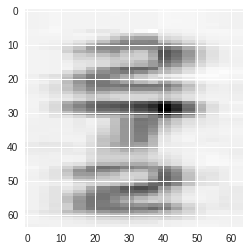

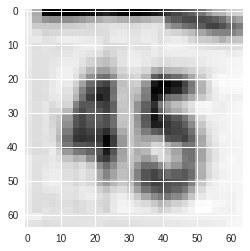

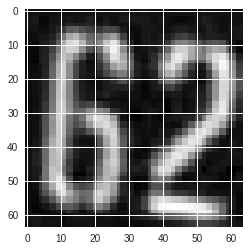

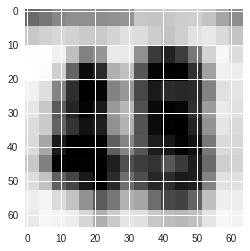

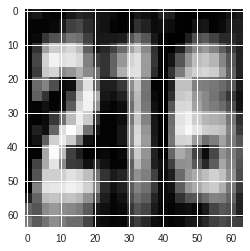

In [21]:
# Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    plt.figure()
    plt.imshow(test_dataset[i])
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Source: https://sajalsharma.com/portfolio/digit_sequence_recognition